# Identify the key factors and predict flight prices

Contributers: Chuheng(Kevin) Yu, Fu-Yi Pao, Jinisha Kande, Shu Wang, Yuhan Wang

***
# Table of Content



>[Identify the key factors and predict flight prices](#scrollTo=e3171661-8582-4bf9-be09-fdd006c594b5)

>[Table of Content](#scrollTo=kHIaBczHeFCs)

>[Problem definition:](#scrollTo=cb460793-2b3f-4d43-bf81-714c836610be)

>[Data Description:](#scrollTo=cb460793-2b3f-4d43-bf81-714c836610be)

>[Source:](#scrollTo=cb460793-2b3f-4d43-bf81-714c836610be)

>[Motivation:](#scrollTo=cb460793-2b3f-4d43-bf81-714c836610be)

>[Data Preparation](#scrollTo=8a06b8c3-eecc-4fc7-b6ba-97bdfa0d9ca2)

>[EDA](#scrollTo=ff82cc87-4aa6-4303-9db9-28b45007eff8)

>>[A. Travel Route](#scrollTo=ff82cc87-4aa6-4303-9db9-28b45007eff8)

>>[B. Travel Time](#scrollTo=ae892128-5ba4-419f-8362-bc9e67b1695f)

>>>[Flight per day](#scrollTo=8c70993d-cfee-47be-98ae-76c0c959967f)

>>>[Weekend vs. weekday](#scrollTo=70f45a88-d024-40ee-bc8a-d41590371e94)

>>[C. Travel Experience](#scrollTo=f4f06f15-8be8-41fa-b7dd-22dc0f08e114)

>>>[Visualization of top 10 airlines](#scrollTo=50f5d312-7947-4e21-98c9-dd9b9ca63846)

>>>[Refund situation for different airlines](#scrollTo=96936999-d3b4-4f9e-8e1d-34686cdfef22)

>>>[Refund situation for basic economy airline and non-basic economy airline](#scrollTo=f64e22eb-975a-43fc-b958-4540b6199f16)

>>[D. Price](#scrollTo=672c146d-2d93-46ab-9904-aaaed9a38e57)

>[Brief Summary & Future Studies](#scrollTo=THDzxWz-kNkQ)



***
# Problem definition: 
Our goal is to identify the key factors of flight prices between 04/16/2022 and 10/05/2022  to generate predictions for our customer.

To achieve this, we will use PySpark for EDA and regression modeling on a large-scale dataset of flight prices and related variables such as departure date, arrival date, airline, etc. Our primary goal will be to identify the factors that have the greatest impact on flight prices during this time period, and to see the strength of these relationships using statistical models.

Afterwards, we shall apply machine learning and regression techniques to develop insights for airfare costs relying on crucial components. These forecasts will offer customers perspectives concerning the ideal timing and price point when they should purchase plane tickets so as to make their expenses more efficient. By doing this, it is our intention to acquire a deeper knowledge of what prompts changes in flight fares.

# Data Description:

This dataset contains information on purchasable flight tickets available on Expedia between 2022-04-16 and 2022-10-05, to/from the following airports: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK. The dataset is available in compressed CSV and Apache Parquet formats.

The dataset consists of 28 columns with the following information:

| Attribute | Defnition |
| ----------- | ----------- |
|legId | An identifier for the flight.|
|searchDate| The date (YYYY-MM-DD) on which this entry was taken from Expedia.|
|flightDate| The date (YYYY-MM-DD) of the flight.|
|startingAirport| Three-character IATA airport code for the initial location.|
|destinationAirport| Three-character IATA airport code for the arrival location.|
|fareBasisCode| The fare basis code.|
|travelDuration| The travel duration in hours and minutes.|
|elapsedDays| The number of elapsed days (usually 0).|
|isBasicEconomy| Boolean for whether the ticket is for basic economy.|
|isRefundable| Boolean for whether the ticket is refundable.|
|isNonStop| Boolean for whether the flight is non-stop.|
|baseFare| The price of the ticket (in USD).|
|totalFare| The price of the ticket (in USD) including taxes and other fees.|
|seatsRemaining| Integer for the number of seats remaining.|
|totalTravelDistance| The total travel distance in miles. This data is |sometimes missing.|
|segmentsDepartureTimeEpochSeconds| String containing the departure time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsDepartureTimeRaw| String containing the departure time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsArrivalTimeEpochSeconds| String containing the arrival time (Unix time) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsArrivalTimeRaw| String containing the arrival time (ISO 8601 format: YYYY-MM-DDThh:mm:ss.000±[hh]:00) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsArrivalAirportCode| String containing the IATA airport code for the arrival location for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsDepartureAirportCode| String containing the IATA airport code for the departure location for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsAirlineName| String containing the name of the airline that services each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsAirlineCode| String containing the two-letter airline code that services each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsEquipmentDescription| String containing the type of airplane used for each leg of the trip (e.g. "Airbus A321" or "Boeing 737-800"). The entries for each of the legs are separated by '||'.|
|segmentsDurationInSeconds| String containing the duration of the flight (in seconds) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsDistance| String containing the distance traveled (in miles) for each leg of the trip. The entries for each of the legs are separated by '||'.|
|segmentsCabinCode| String containing the cabin for each leg of the trip (e.g. "coach"). The entries for each of the legs are separated by '||'.|



# Source: 
Expedia
Link: https://www.kaggle.com/datasets/dilwong/flightprices
# Motivation: 
As international students who travel a lot between our home country and US, it is crucial for us to find the best value for flight tickets during the summer vacation period.


***
# Data Preparation

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.types import (StructType, 
                               StructField, 
                               DateType, 
                               BooleanType,
                               DoubleType,
                               IntegerType,
                               StringType,
                               TimestampType)

flight_schema = StructType([StructField("legId", StringType(), True),
                            StructField("searchDate", StringType(), True),
                            StructField("flightDate", DateType(), True),
                            StructField("startingAirport", StringType(), True),
                            StructField("destinationAirport", StringType(), True),
                            StructField("fareBasisCode", StringType(), True),
                            StructField("travelDuration", StringType(), True),
                            StructField("elapsedDays", IntegerType(), True ),
                            StructField("isBasicEconomy", BooleanType(), True),
                            StructField("isRefundable", BooleanType(), True),
                            StructField("isNonStop", BooleanType(), True),
                            StructField("baseFare", DoubleType(), True),
                            StructField("totalFare", DoubleType(), True),
                            StructField("seatsRemaining", IntegerType(), True),
                            StructField("totalTravelDistance", IntegerType(), True),
                            StructField("segmentsDepartureTimeEpochSeconds", IntegerType(), True),
                            StructField("segmentsDepartureTimeRaw", TimestampType(), True),
                            StructField("segmentsArrivalTimeEpochSeconds", IntegerType(), True),
                            StructField("segmentsArrivalTimeRaw", TimestampType(), True),
                            StructField("segmentsArrivalAirportCode", StringType(), True),
                            StructField("segmentsDepartureAirportCode", StringType(), True),
                            StructField("segmentsAirlineName", StringType(), True),
                            StructField("segmentsAirlineCode", StringType(), True),
                            StructField("segmentsEquipmentDescription", StringType(), True),
                            StructField("segmentsDurationInSeconds", IntegerType(), True),
                            StructField("segmentsDistance", IntegerType(), True ),
                            StructField("segmentsCabinCode", StringType(), True)
                            ])

In [ ]:
data_path = "gs://is843-teamproject/itineraries.csv"

In [ ]:
 data = spark.read.format("csv")\
  .option("header", "true")\
  .schema(flight_schema)\
  .load(data_path)

In [ ]:
data.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: integer (nullable = true)
 |-- segmentsDepartureTimeRaw: timestamp (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: integer (nullable = true)
 |-- segmentsArrivalTimeRaw: timestamp (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirp

In [ ]:
data.limit(3).toPandas()

23/04/02 18:40:45 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17 19:26:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17 13:00:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach
2,98d90cbc32bfbb05c2fc32897c7c1087,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650218700,2022-04-17 18:05:00,BOS,ATL,Delta,DL,Boeing 757-200,9000,947,coach


***
# EDA

## A. Travel Route
To determine the most popular airport for departure and destination, we will need to analyze the flight price data and count the number of flights departing or arriving at each airport. To add the geographical coordinates of each airport, we import a dataset called "airport_zip" from https://www.partow.net/miscellaneous/airportdatabase that includes longitude and latitude information. This will allow us to plot a map later on.

In [ ]:
#Import airport_zipcode dataset
airport_zip_path = "gs://is843-teamproject/GlobalAirportDatabase.csv"
airport_zip_schema= StructType([
    StructField("ICAO Code", StringType(), True),
    StructField("IATA Code", StringType(), True),
    StructField("Airport Name", StringType(), True),
    StructField("City/Town", StringType(), True),
    StructField("Country", StringType(), True),
    StructField("Latitude Degrees", IntegerType(), True),
    StructField("Latitude Minutes", IntegerType(), True),
    StructField("Latitude Seconds", IntegerType(), True),
    StructField("Latitude Direction", StringType(), True),
    StructField("Longitude Degrees", IntegerType(), True),
    StructField("Longitude Minutes", IntegerType(), True),
    StructField("Longitude Seconds", IntegerType(), True),
    StructField("Longitude Direction", StringType(), True),
    StructField("Altitude", IntegerType(), True),
    StructField("Latitude Decimal Degrees", DoubleType(), True),
    StructField("Longitude Decimal Degrees", DoubleType(), True)
])

airport_zipcode = spark.read.format("csv")\
  .option("header", "true")\
  .schema(airport_zip_schema)\
  .load(airport_zip_path)

In [ ]:
# Join the flight_price and airport_zipcode
flight_airport = data.join(airport_zipcode, data.startingAirport == airport_zipcode['IATA Code'], 'left_outer')

# count the number of departure and destination airport
departure_counts = flight_airport.groupBy('startingAirport').agg(count('*').alias('count'))
destination_counts = flight_airport.groupBy('destinationAirport').agg(count('*').alias('count'))

# Rename columns and join counts
airport_zipcode = airport_zipcode.withColumnRenamed('IATA Code', 'airportCode')
departure_airport_data = airport_zipcode.join(departure_counts, airport_zipcode.airportCode == departure_counts.startingAirport, 'left_outer')
destination_airport_data = airport_zipcode.join(destination_counts, airport_zipcode.airportCode == destination_counts.destinationAirport, 'left_outer')

# Convert latitude and longitude to floats
departure_airport_data = departure_airport_data.withColumn('latitude', col('Latitude Decimal Degrees').cast('float'))
departure_airport_data = departure_airport_data.withColumn('longitude', col('Longitude Decimal Degrees').cast('float'))
destination_airport_data = destination_airport_data.withColumn('latitude', col('Latitude Decimal Degrees').cast('float'))
destination_airport_data = destination_airport_data.withColumn('longitude', col('Longitude Decimal Degrees').cast('float'))

# Filter count=0
departure_airport_data = departure_airport_data.filter(col('count').isNotNull())
destination_airport_data = destination_airport_data.filter(col('count').isNotNull())

# Convert the dataframes to Pandas dataframes for plotting
departure_airport_data_pd = departure_airport_data.select('airportCode', 'latitude', 'longitude', 'count').toPandas()
destination_airport_data_pd = destination_airport_data.select('airportCode', 'latitude', 'longitude', 'count').toPandas()

Next, we attempted to identify the top 5 departure and destination airports with the highest volumes. According to the result, the top departure airports are **LGA, BOS, DFW, SFO, and LAX**, while LGA and BOS are the top two departure airports with **5.9 million** and **5.8 million** departure counts, respectively. Similarly, the top destination airports are **LGA, BOS, DFW, ORD, and LAX**. It's interesting to note that SFO and LAX appear only in the top departure list. It is possible that SFO and LAX airports may have more domestic departures compared to other airports because it is a popular destination for international travelers. These travelers may transfer to domestic flights from these two airports to travel within the US.

In [ ]:
top_departure_airports = departure_airport_data_pd.nlargest(5, 'count')
top_destination_airports = destination_airport_data_pd.nlargest(5, 'count')
airport_counts = pd.DataFrame({
    'Top Departure Airports': top_departure_airports['airportCode'],
    'Departure Counts': top_departure_airports['count'],
    'Top Destination Airports': top_destination_airports['airportCode'],
    'Destination Counts': top_destination_airports['count']
})
print(airport_counts)

   Top Departure Airports  Departure Counts Top Destination Airports  \
1                     LGA         5919323.0                      LGA   
2                     BOS         5883876.0                      BOS   
8                     DFW         5674959.0                      DFW   
9                     SFO         5706482.0                      NaN   
11                    NaN               NaN                      ORD   
13                    LAX         8073281.0                      LAX   

    Destination Counts  
1            6093450.0  
2            5801538.0  
8            5957280.0  
9                  NaN  
11           5717699.0  
13           8006721.0  


In [ ]:
import folium
import folium.plugins as plugins

center_location = [39.8283, -98.5795]
zoom_level = 4
m = folium.Map(location=center_location, zoom_start=zoom_level)

# Define label
departure_color = 'blue'
destination_color = 'red'

# Add markers to the map for the departure airports
for index, row in departure_airport_data_pd.iterrows():
    count = row['count']
    airport_code = row['airportCode']
    airport_name = row['airportCode']
    latitude = row['latitude']
    longitude = row['longitude']
    radius=row['count']/150000
    folium.CircleMarker(location=[latitude, longitude], radius=radius, color=departure_color, fill_color=departure_color, fill_opacity=0.7).add_to(m)
    folium.Marker(location=[latitude, longitude], tooltip=airport_name, icon=None).add_to(m)

# Add markers to the map for the destination airports
for index, row in destination_airport_data_pd.iterrows():
    count = row['count']
    airport_code = row['airportCode']
    airport_name = row['airportCode']
    latitude = row['latitude']
    longitude = row['longitude']
    radius=row['count']/150000
    folium.CircleMarker(location=[latitude, longitude], radius=radius, color=destination_color, fill_color=destination_color, fill_opacity=0.7).add_to(m)
    folium.Marker(location=[latitude, longitude], tooltip=airport_name, icon=None).add_to(m)

# Display the map
m

After analyzing the data we collected, a comprehensive map was created which showcases the most commonly used airports across all of mainland USA. From this map it appears that travelers in Bay Area frequent **LAX, SFO and OAK** as their go-to airports for travel purposes. However, on the other side of America along with Central American countries like **EWR, PHL, BOS, LGA, JFK and IAD** are more popular amongst people's choice for air travels based on high volume footfall recorded at these hubs. Similarly further southward towards central America large amounts passengers opt to navigate through **CLT, ATL, DTW, ORD, DFT or DEN airport terminals** when they have flights to catch.Lastly down Southwards around **MIA** region majority airlines is found landing there being favored by many travellers .

## B. Travel Time

### Flight per day

In [ ]:
from pyspark.sql.functions import year

# assuming you have a SparkSession called 'spark' and a DataFrame called 'df' with a time variable column called 'timestamp'
year_to_filter = 2022

filtered_df = data.filter(year(data.flightDate) == year_to_filter)

In [ ]:
flight_per_month = data.groupBy(F.date_format(F.col("flightDate"), 'yyyy-MM').alias("Date")).agg(F.count("legId").alias("flight_count")).orderBy("Date")

# Convert to Pandas
py_flights_per_month = flight_per_month.toPandas()
py_flights_per_month.head()

,Date,flight_count
0,2022-04,918956
1,2022-05,7440297
2,2022-06,11774933
3,2022-07,13492890
4,2022-08,17678497


We can see that July, August, September have the highest number of flights. This may be because Summer vacation usually falls in that time span.

In [ ]:
from pyspark.sql.functions import date_format

from pyspark.sql.functions import desc

# assuming you have a SparkSession called 'spark' and a DataFrame called 'df' with a date column called 'date_column'
groupedate = data.groupBy(date_format(data.flightDate, 'yyyy-MM-dd').alias('date')).count().orderBy(desc('count'))

groupedate.head()

Row(date='2022-08-30', count=729117)

In [ ]:
groupedate.show()

+----------+------+
|      date| count|
+----------+------+
|2022-08-30|729117|
|2022-09-07|695010|
|2022-09-13|690912|
|2022-09-08|671131|
|2022-08-31|667996|
|2022-08-23|666408|
|2022-08-24|658937|
|2022-09-20|655025|
|2022-08-29|654670|
|2022-09-14|636895|
|2022-10-04|632812|
|2022-09-09|629272|
|2022-08-25|624789|
|2022-08-09|624201|
|2022-08-26|623255|
|2022-09-06|613194|
|2022-09-21|612786|
|2022-09-27|612244|
|2022-09-01|611926|
|2022-09-12|608266|
+----------+------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import date_format

from pyspark.sql.functions import desc
groupdate = data.groupBy(date_format(data.flightDate, 'yyyy-MM-dd').alias('date')).count()
flights_per_day = groupdate.toPandas()

In [ ]:
data_week = data.withColumn('week', F.weekofyear('flightDate'))

groupweek = data_week.groupBy('week').count()
flights_per_week = groupweek.toPandas()

In [ ]:
plt.style.use('ggplot')

''

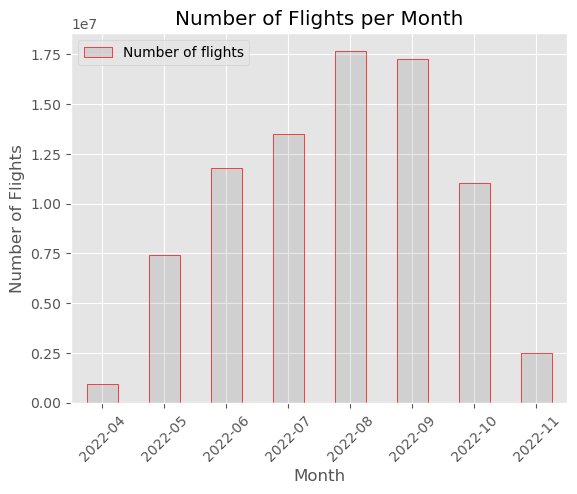

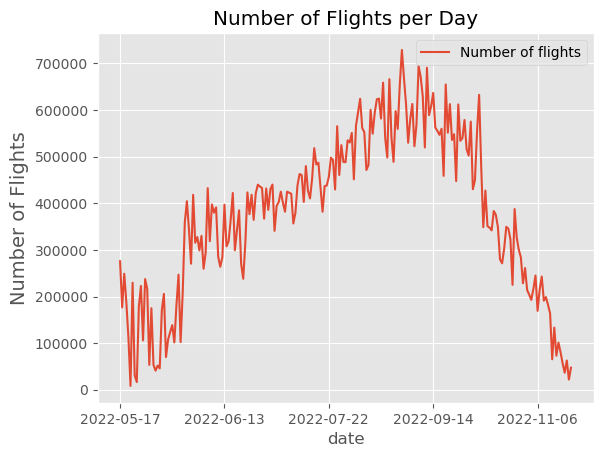

In [ ]:
df.plot.bar(color=(0.1, 0.1, 0.1, 0.1),  edgecolor='red')
plt.xticks(rotation=45)
plt.ylabel("Number of Flights", fontsize = 12)
plt.xlabel("Month", fontsize = 12)
plt.title('Number of Flights per Month')
plt.legend(["Number of flights"])

df2 = flights_per_day.set_index('date')
df2.plot.line()

plt.ylabel("Number of Flights", fontsize = 14)
plt.title('Number of Flights per Day')
plt.grid(True)
plt.legend(["Number of flights"])
;

Based on the graph of flights per day and flights per month,we saw a seasonal trend of total number of flights within a month.The local peaks of flights occurs on weekends and then started to decrease. August and September has the highest number of flights in a year suggesting that vacation days has a higher volume of flights nationwide.

### Weekend vs. weekday

In [ ]:
from pyspark.sql.functions import dayofweek

data_week = data_week.withColumn("is_weekend", dayofweek("flightDate").isin([1,7]).cast("int"))

In [ ]:
data_week.show(10)

23/04/02 20:20:19 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+----+----------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode| segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationIn

In [ ]:
groupend = data_week.groupBy('is_weekend').count()
flights_weekend = groupend.toPandas()

In [ ]:
flights_weekend

,is_weekend,count
0,1,21043976
1,0,61094777


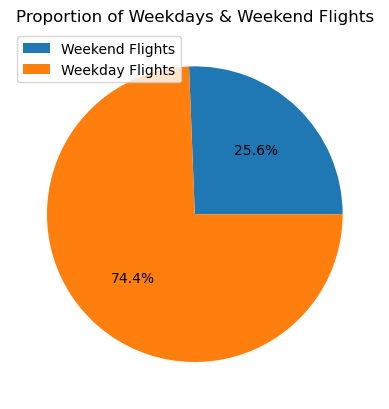

In [ ]:
import matplotlib.pyplot as plt

plt.pie(flights_weekend['count'],  autopct='%1.1f%%')

plt.title('Proportion of Weekdays & Weekend Flights')

plt.legend(["Weekend Flights",'Weekday Flights']);
# Show the pie chart
plt.show()

According to the pie chart its clear that there are 25.6% flight bookings in the dataset that are on a weekend, while the second row shows that there are 74.4% flight bookings that are not on a weekend. This suggests that a significant portion of the flight bookings in the dataset are for weekend travel.

## C. Travel Experience

In [ ]:
top_10_airline = data.groupBy('segmentsAirlineName').agg(count('*').alias('tol_tickets')).orderBy('tol_tickets', ascending=False).limit(10)
top_10_airline = top_10_airline.toPandas()

top_10_airline.head(10)

,segmentsAirlineName,tol_tickets
0,American Airlines||American Airlines,16296340
1,Delta||Delta,11351669
2,United||United,10217320
3,American Airlines,7453245
4,Delta,4855169
5,United,4531426
6,Spirit Airlines||Spirit Airlines,4215514
7,JetBlue Airways,3578393
8,JetBlue Airways||JetBlue Airways,3129646
9,Alaska Airlines||Alaska Airlines,1777996


### Visualization of top 10 airlines

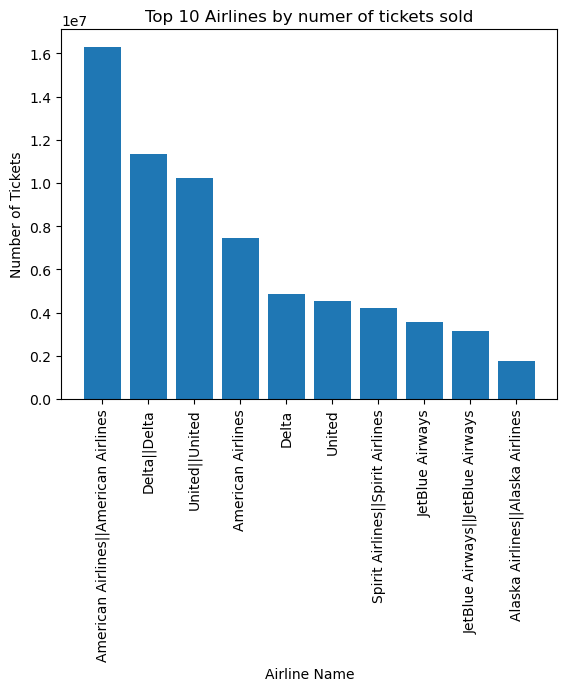

In [ ]:
plt.bar(top_10_airline['segmentsAirlineName'], top_10_airline['tol_tickets'])
plt.title('Top 10 Airlines by numer of tickets sold')
plt.xticks(rotation=90)
plt.xlabel('Airline Name')
plt.ylabel('Number of Tickets')
plt.show()

We can see that **American Airlines** takes the lead followed by **United** and then **Delta**.

### Refund situation for different airlines

In [ ]:
from pyspark.sql.functions import sum, round, when

df2 = data.withColumn("refundable_or_not", when(data["isRefundable"] == True, 1).otherwise(0))
airline_refund= df2.groupBy('segmentsAirlineName').agg(count('*').alias('tol_tickets'), sum(df2['refundable_or_not']).alias('refundable_tickets')) \
                      .where(col('refundable_tickets') > 0)
airline_refund = airline_refund.withColumn('refundable_percentage', round((col('refundable_tickets') / col('tol_tickets') * 100), 2)) \
                      .orderBy('refundable_percentage', ascending=False)

airline_refund = airline_refund.toPandas()
airline_refund.head()

,segmentsAirlineName,tol_tickets,refundable_tickets,refundable_percentage
0,American Airlines||JetBlue Airways,388,388,100.00
1,JetBlue Airways||American Airlines,13,13,100.00
2,Key Lime Air||Key Lime Air,11532,905,7.85
3,American Airlines||Key Lime Air||Key Lime Air,17087,26,0.15


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


There are four segments:

* American Airlines||JetBlue Airways

* JetBlue Airways||American Airlines

* Key Lime Air||Key Lime Air

* American Airlines||Key Lime Air||Key Lime Air

For the first two segments, all tickets that were purchased were refundable, with 100% refundable percentage. For the third segment, there were 11,532 total tickets purchased, out of which 905 tickets were refundable, resulting in a refundable percentage of 7.85%. For the fourth segment, there were 17,087 total tickets purchased, from which only 26 tickets were refundable which caused a very low refundable percentage of 0.15%.  

### Refund situation for basic economy airline and non-basic economy airline

In [ ]:
airline_type_refund = df2.groupBy('isBasicEconomy').agg(count('*').alias('tol_tickets'),sum(df2['refundable_or_not']).alias('refundable_tickets'))
airline_type_refund = airline_type_refund.withColumn('refundable_percentage', round((col('refundable_tickets') / col('tol_tickets') * 100), 5)) \
                                               .orderBy('refundable_percentage', ascending=False)

print(airline_type_refund.show())

+--------------+-----------+------------------+---------------------+
|isBasicEconomy|tol_tickets|refundable_tickets|refundable_percentage|
+--------------+-----------+------------------+---------------------+
|         false|   70313487|              1332|              0.00189|
|          true|   11825266|                 0|                  0.0|
+--------------+-----------+------------------+---------------------+

None


This table shows the total number of tickets purchased for basic economy and non-basic economy fares, as well as the number of refundable tickets and the percentage of refundable tickets for each fare type.

As seen in the table, more than 70 million tickets purchased were for fares other than basic economy. In comparison, a little over 11 million tickets were of basic economy fare type. A mere fraction of non-basic economy tickets amounting to only around 0.00189% could be refunded while refunds weren't available for any of the basic economy ticket holders.

## D. Price

In [ ]:
data.selectExpr("min(totalFare)", "max(totalFare)").show()

+--------------+--------------+
|min(totalFare)|max(totalFare)|
+--------------+--------------+
|         19.59|       8260.61|
+--------------+--------------+



The above table displays the minimum and maximum total fare values in the dataset, which range from 19.59 dollars  to  8260.61 dollars.

In [ ]:
%matplotlib inline
num_airline = data.groupBy("segmentsAirlineName").avg("totalFare")
df = num_airline.toPandas()
df = df.set_index('segmentsAirlineName')

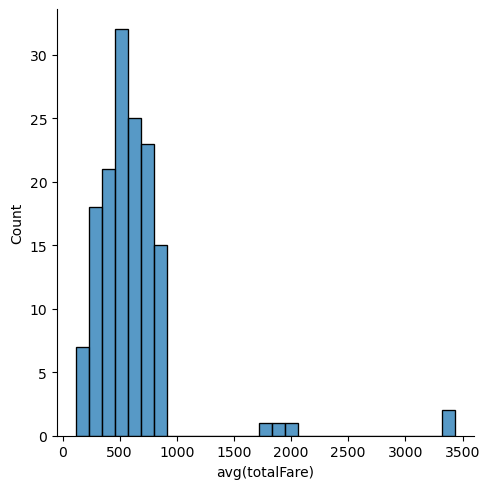

In [ ]:
#for_graph = data.toPandas()
sns.displot(df['avg(totalFare)'])
plt.show()

From the above graph, we can see that most plane ticket prices are below 1,000 dollars for a United States domestic flight. Where there are some flights charge customers around 2,000 dollars and some charge about 3,400 dollars.

In [ ]:
df = df.sort_values(by=['avg(totalFare)'], ascending=False)
df.head(10)

,avg(totalFare)
segmentsAirlineName,
JetBlue Airways||American Airlines,3431.598462
American Airlines||JetBlue Airways,3429.437655
United||Cape Air||Cape Air||Alaska Airlines,2047.551944
Cape Air||Delta||Delta,1934.000000
Cape Air||Cape Air||Alaska Airlines,1795.670000
Cape Air||Cape Air||Cape Air||Delta,915.386117
Cape Air||Cape Air||Cape Air||JetBlue Airways,906.900000
Delta||United||Cape Air,906.010000
Delta||United||United||Delta,902.343562


The above table shows the average total fare for different combinations of Airlines.
* The highest average fare is for the combination of **JetBlue Airways and American Airlines**, with an average of **3431.598462**.
* The combination of **American Airlines and JetBlue Airways** has a similar average fare of **3429.437655**.
* The third highest average fare is for the combination of **United, Cape Air, Cape Air, and Alaska Airlines**, with an average of **2047.551944**.
* The lowest average fare is for the combination of **Cape Air, Cape Air, and Cape Air, and Delta**, with an average of **915.386117**.

Other combinations include Delta, United, Cape Air, Hawaiian Airlines, and Alaska Airlines

In [ ]:
num_airline = data.groupBy("flightDate").avg("totalFare")
df = num_airline.toPandas()
df = df.set_index('flightDate')
df = df.sort_values(by=['avg(totalFare)'], ascending=False)

In [ ]:
df.head(10)

,avg(totalFare)
flightDate,
2022-04-24,524.246711
2022-06-26,485.382266
2022-06-12,480.520908
2022-05-15,475.938415
2022-05-22,467.165279
2022-07-01,460.841785
2022-06-19,457.104280
2022-06-05,453.164056
2022-07-17,448.814123


The data provided above depicts the average total fare for distinct flight dates. Based on the given information, **April 24th's** flight has recorded as having the highest rate totaling to around **524.246711**, while **July 10th’s** travel expenditure is noted at a nominal expense amounting to nearly **444.209536** only- which makes it have less than most other flights’ traveling expenses so far revealed in this report presently.The conclusion that one can formulate from analysing these facts and figures suggests that throughout June and July months’, airplane tickets are generally expensive, however during springtime such as May and especially earlier month starting April onwards till mid-May or later they are reasonably inexpensive with almost no increase!

# Brief Summary & Future Studies

From our insights we can see that:
* The top departure airports are LGA, BOS, DFW, SFO, and LAX.
* The top destination airports are LGA, BOS, DFW, ORD, and LAX
* The months of July, August, September have the highest number of flights.
* American Airlines || American Airlines is the most popular Airline according to the number tickets sold.
* The highest average fare is for the combination of JetBlue and American Airlines.


There are several directions in which this project could be extended in the future some ideas being:

**Incorporating customer data:** In this project, we are focused on the relationship between flight prices and objective variables such as departure date and airline. But, there may be other subjective factors that influence a customer's decision to book a flight, such as brand loyalty or personal preferences. 

**Expanding the time frame:** Our project focuses on flight prices between 04/16/2022 and 10/05/2022. However, analyzing flight prices over a longer time frame could reveal seasonal trends or long-term patterns that are not visible in our current dataset.




